## データの収集
https://smashmate.net/rate/ からレート戦の戦績をスクレイピングして、以下のデータをdbに投げる

|name|type|
|-----|-----|
|game_id|int|
|rating_period|datetime|
|player_1_id|int|
|player_1_rate|int|
|player_1_character|str|
|player_1_status|int(win: 1 or lose: 0)|
|player_1_url|str|
|player_2_id|int|
|player_2_rate|int|
|player_2_character|str|
|player_2_status|int(win: 1 or lose: 0)|
|player_2_url|str|

https://smashmate.net/rate/{gameid}/　から上のデータが取れる。gameidは1から連番なの見つからなくなるまでやれば良いと思ったが、飛ぶ時があるので、終了する値を決めておく、次収集するときは空き番号から収集

icon はhttps://smashmate.net/img/icon/{character}.png で取れる
img class="smash-icon" src="https://smashmate.net/img/icon/toon_link.png">

### 例外
- ValueError: 退会していると名前がないため、unpack できない => 飛ばす
- ValueError: urlないとsoupが空でplayer1, player2 がunpackできない => 飛ばす
- 募集中だと二人目が空の辞書

In [40]:
import time
import pickle
import pandas as pd
import numpy as np
import sqlite3
from contextlib import closing
from tqdm import tqdm_notebook as tqdm
import time
import re
import datetime
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
def get_game_soup(gameid):
    res = requests.get(f'https://smashmate.net/rate/{gameid}/')
    return BeautifulSoup(res.text, 'html.parser')

In [42]:
not_n_t_pattern = re.compile(r'[^\n\t]+')
def collect_info(soup):
    l = []
    for player in soup.find_all(class_='col-xs-6'):
        d = {}
        for col in player.find_all(class_='row row-center va-middle'):
            try:
                k, v = re.findall(not_n_t_pattern, col.text)
            except ValueError:
                continue
            try:
                if k == '配信URL':
                    v = col.find('a').get('href')
                elif k == '使用キャラ':
                    v = ','.join([a.get('href').split('/')[-2] for a in col.find_all('a')])
                else:
                    v = col.find('a').get('href').split('/')[-2]
            except AttributeError:
                pass
            d[k] = v
        l.append(d)
    return l

In [43]:
def int_or_none(v):
    try:
        return int(v)
    except TypeError:
        return None
    except ValueError:
        print(v)
        return None

translate_status = {'勝ち': 1, '負け': 0}
insert_sql = 'insert into game_result values (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)'

def throw_info(d_list, game_id, rating_period, cursor):
    if len(d_list) != 2:
        return 0
    d1, d2 = d_list
    if d1.get('ステータス') not in ['勝ち', '負け'] or d2.get('ステータス') not in ['勝ち', '負け']:
        return 0
    vec = (game_id, rating_period, 
           int_or_none(d1.get('プレイヤー')), int_or_none(d1.get('レート')), d1.get('使用キャラ'), translate_status[d1.get('ステータス')], d1.get('配信URL'),
           int_or_none(d2.get('プレイヤー')), int_or_none(d2.get('レート')), d2.get('使用キャラ'), translate_status[d2.get('ステータス')], d2.get('配信URL')
          )
    c.execute(insert_sql, vec)
    return 1

In [44]:
collect_info(get_game_soup(300))

[{'プレイヤー': '48362',
  'レート': '1457',
  '使用キャラ': 'mii_brawler,rob',
  'ステータス': '勝ち',
  'コメント': 'ありがとナス！'},
 {'レート': '1462', '使用キャラ': 'joker', 'ステータス': '負け', 'コメント': 'ありがとうございました'}]

In [53]:
import sqlite3
from contextlib import closing
from tqdm import tqdm_notebook as tqdm
import time
from requests.exceptions import Timeout, ConnectionError


dbpath = './data/game_result.db'
period = datetime.date(2020, 1, 12)
last_game_id = 38792
make_table_flg = False
if make_table_flg:
    with closing(sqlite3.connect(dbpath, detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)) as conn:
        c = conn.cursor()
        # c.execute('drop table if exists game_result')
        c.execute('''CREATE TABLE IF NOT EXISTS game_result
                     (game_id int, rating_period datetime, 
                      player_1_id int, player_1_rate int, player_1_character str, player_1_status int, player_1_url str, 
                      player_2_id int, player_2_rate int, player_2_character str, player_2_status int, player_2_url str)''')
        conn.commit()
if True:
    with closing(sqlite3.connect(dbpath, detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)) as conn:
        c = conn.cursor()
        done_game_id = set([i for i, in c.execute(f'select game_id from game_result where rating_period = "{period.strftime("%Y-%m-%d")}"')])
        game_ids = list(set(range(last_game_id+1)) - done_game_id)
        for game_id in tqdm(game_ids):
            d_list = collect_info(get_game_soup(game_id))
            res = throw_info(d_list, game_id, period, c)
            time.sleep(0.1)
            if game_id % 1000 == 0:
                conn.commit()
                time.sleep(10)
        conn.commit()

In [52]:
last_game_id = 38792
if True:
    with closing(sqlite3.connect(dbpath, detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)) as conn:
        c = conn.cursor()
        done_game_id = set([i for i, in c.execute(f'select game_id from game_result where rating_period = "{period.strftime("%Y-%m-%d")}"')])
        game_ids = list(set(range(last_game_id+1)) - done_game_id)
        for game_id in tqdm(game_ids):
            if game_id in done_game_id:
                print(game_id)

/Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [119]:
game_id

1767

In [54]:
period = datetime.date(2020, 1, 12)
dbpath = './data/game_result.db'

with closing(sqlite3.connect(dbpath, detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)) as conn:
    c = conn.cursor()
    characters = {c_name if c_name is None or c_name.find(',')==-1 else None for c_name, in c.execute('select player_1_character from game_result')} | {c_name if c_name is None or c_name.find(',')==-1 else None for c_name, in c.execute('select player_2_character from game_result')}
    characters.remove(None)
    characters_idx = {chara: idx for idx, chara in enumerate(characters)}
    n_chara = len(characters)
    n_match_mat = np.zeros((n_chara, n_chara))
    n_win_mat = np.zeros((n_chara, n_chara))
    for chara1, chara2, status1, status2 in c.execute(f'select player_1_character, player_2_character, player_1_status, player_2_status from game_result where rating_period = "{period.strftime("%Y-%m-%d")}"'):
        if chara1 is None or chara2 is None or chara1.find(',')!=-1 or chara2.find(',')!=-1:
            continue
        idx1 = characters_idx[chara1]
        idx2 = characters_idx[chara2]
        # n_win_mat/n_match_mat[i, j] はiのjに対する勝率
        n_match_mat[idx1][idx2] += 1
        n_match_mat[idx2][idx1] += 1
        n_win_mat[idx1][idx2] += status1
        n_win_mat[idx2][idx1] += status2

/Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


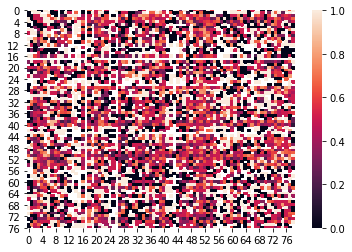

In [141]:
sns.heatmap(n_win_mat/n_match_mat)

In [61]:
from bokeh.plotting import figure, show, output_file, output_notebook
from scipy.cluster.hierarchy import linkage, dendrogram
from bokeh.models import CategoricalTicker, TickFormatter
from bokeh.util.compiler import TypeScript

# output_notebook()


def get_order(linkage_data):
    return dendrogram(linkage_data, no_plot=True)['leaves']


xname = []
yname = []
color = []
alpha = []
val = []
val_opp = []
match = []
win_rate_mat = n_win_mat/n_match_mat
# 行列の形のために[ychara, xchara]
for chara1 in characters:
    for chara2 in characters:
        yname.append(chara1)
        xname.append(chara2)
        n_win = n_win_mat[characters_idx[chara1],characters_idx[chara2]]
        n_match = n_match_mat[characters_idx[chara1],characters_idx[chara2]]
        v = n_win/n_match if n_match!=0 else 0.5
        val.append(n_win)
        val_opp.append(n_match-n_win)
        match.append(n_match)
        color.append('aqua' if v>=0.5 else 'salmon')
        alpha.append(abs(v-0.5)*2)
        
data=dict(
    xname=xname,
    yname=yname,
    colors=color,
    alphas=alpha,
    vals=val,
    vals_opp=val_opp,
    n_match=match
)

# chara_list = list(reversed(sorted(characters)))
win_rate_mat_fill_nan = win_rate_mat
win_rate_mat_fill_nan[np.isnan(win_rate_mat_fill_nan)] = 0.5
cluster_order_idx = get_order(linkage(win_rate_mat_fill_nan>0.5, method='ward'))
idx2chara = {k: v for v, k in characters_idx.items()}
chara_list = list(map(lambda idx: idx2chara[idx], cluster_order_idx))
tooltips = """
    <div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">@yname: @vals/@n_match</span>
            <img class="smash-icon" src="https://smashmate.net/img/icon/@yname.png">
        </div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">vs</span>
        </div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">@xname: @vals_opp/@n_match</span>
            <img class="smash-icon" src="https://smashmate.net/img/icon/@xname.png">
        </div>
    </div>
"""
p = figure(title="smash",
           x_axis_location="above", tools="hover",
           x_range=list(reversed(chara_list)), y_range=chara_list,
           tooltips = tooltips)

p.plot_width = 1600
p.plot_height = 1600
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3

p.rect('xname', 'yname', 0.9, 0.9, source=data,
       color='colors', alpha='alphas', line_color=None,
       hover_line_color='black', hover_color='colors')
output_file('index.html')
show(p) # show the plot

/Users/ht/.pyenv/versions/miniconda3-latest/envs/cert/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [60]:
sorted_idx = np.argsort(n_win_mat.sum(axis=1)/n_match_mat.sum(axis=1))
s = '|name|win/match|rate|\n|-----|-----|-----|\n'
for idx, match, win in zip(sorted_idx, n_match_mat.sum(axis=1)[sorted_idx], n_win_mat.sum(axis=1)[sorted_idx]):
    s += f'|{idx2chara[idx]}|{win}/{match}|{win/match*100}%|\n'
print(s)
with open('./winrate.md', 'w') as f:
    f.write(s)

|name|win/match|rate|
|-----|-----|-----|
|kirby|67.0/234.0|28.63247863247863%|
|jigglypuff|75.0/198.0|37.878787878787875%|
|pichu|42.0/108.0|38.88888888888889%|
|simon|15.0/38.0|39.473684210526315%|
|young_link|25.0/62.0|40.32258064516129%|
|mr_game_and_watch|156.0/367.0|42.50681198910082%|
|king_dedede|236.0/551.0|42.83121597096189%|
|mii_brawler|3.0/7.0|42.857142857142854%|
|olimar|50.0/114.0|43.859649122807014%|
|chrom|204.0/460.0|44.34782608695652%|
|fox|138.0/311.0|44.37299035369775%|
|wario|171.0/381.0|44.881889763779526%|
|lucas|158.0/352.0|44.88636363636363%|
|lucina|274.0/607.0|45.14003294892916%|
|joker|590.0/1297.0|45.48959136468774%|
|robin|241.0/529.0|45.55765595463138%|
|falco|166.0/364.0|45.604395604395606%|
|corrin|151.0/326.0|46.31901840490797%|
|wolf|310.0/669.0|46.337817638266074%|
|ganondorf|290.0/620.0|46.774193548387096%|
|donkey_kong|518.0/1105.0|46.87782805429864%|
|king_k_rool|144.0/305.0|47.21311475409836%|
|pit|77.0/163.0|47.239263803680984%|
|mario|215.0/45

|name|win/match|rate|
|-----|-----|-----|
|kirby|56.0/202.0|27.722772277227726%|
|jigglypuff|42.0/124.0|33.87096774193548%|
|pichu|21.0/62.0|33.87096774193548%|
|simon|15.0/38.0|39.473684210526315%|
|king_dedede|157.0/379.0|41.42480211081794%|
|olimar|27.0/65.0|41.53846153846154%|
|chrom|140.0/334.0|41.91616766467065%|
|young_link|13.0/31.0|41.935483870967744%|
|lucas|93.0/218.0|42.6605504587156%|
|mii_brawler|3.0/7.0|42.857142857142854%|
|falco|97.0/224.0|43.30357142857143%|
|lucina|151.0/344.0|43.895348837209305%|
|ryu|27.0/61.0|44.26229508196721%|
|sheik|31.0/70.0|44.285714285714285%|
|fox|105.0/234.0|44.871794871794876%|
|mr_game_and_watch|88.0/196.0|44.89795918367347%|
|piranha_plant|76.0/168.0|45.23809523809524%|
|corrin|100.0/220.0|45.45454545454545%|
|donkey_kong|334.0/730.0|45.75342465753425%|
|king_k_rool|103.0/225.0|45.77777777777778%|
|joker|469.0/1021.0|45.93535749265426%|
|banjo_and_kazooie|87.0/189.0|46.03174603174603%|
|robin|164.0/354.0|46.32768361581921%|
|ganondorf|181.0/387.0|46.770025839793284%|
|wolf|195.0/414.0|47.10144927536232%|
|wario|136.0/285.0|47.719298245614034%|
|mario|146.0/304.0|48.026315789473685%|
|villager|40.0/83.0|48.19277108433735%|
|dark_pit|48.0/99.0|48.484848484848484%|
|greninja|378.0/779.0|48.52374839537869%|
|zero_suit_samus|187.0/385.0|48.57142857142857%|
|pokemon_trainer|147.0/302.0|48.675496688741724%|
|roy|105.0/213.0|49.29577464788733%|
|isabelle|71.0/144.0|49.30555555555556%|
|peach|72.0/146.0|49.31506849315068%|
|little_mac|76.0/154.0|49.35064935064935%|
|palutena|203.0/410.0|49.51219512195122%|
|shulk|139.0/279.0|49.82078853046595%|
|sonic|90.0/180.0|50.0%|
|dr_mario|59.0/118.0|50.0%|
|marth|129.0/257.0|50.19455252918288%|
|captain_falcon|181.0/360.0|50.27777777777778%|
|ice_climber|103.0/204.0|50.49019607843137%|
|ness|174.0/343.0|50.72886297376093%|
|hero|94.0/182.0|51.64835164835166%|
|ridley|71.0/137.0|51.82481751824818%|
|bowser|252.0/486.0|51.85185185185185%|
|toon_link|117.0/225.0|52.0%|
|yoshi|234.0/448.0|52.23214285714286%|
|zelda|169.0/323.0|52.32198142414861%|
|ken|161.0/306.0|52.614379084967325%|
|megaman|150.0/283.0|53.003533568904594%|
|terry|114.0/215.0|53.02325581395348%|
|link|239.0/450.0|53.11111111111111%|
|cloud|253.0/476.0|53.15126050420168%|
|pikachu|49.0/92.0|53.2608695652174%|
|inkling|244.0/457.0|53.39168490153173%|
|ike|147.0/275.0|53.45454545454545%|
|metaknight|89.0/166.0|53.6144578313253%|
|lucario|69.0/128.0|53.90625%|
|luigi|155.0/284.0|54.5774647887324%|
|pit|60.0/109.0|55.04587155963303%|
|pacman|106.0/192.0|55.208333333333336%|
|daisy|88.0/159.0|55.34591194968554%|
|incineroar|56.0/100.0|56.00000000000001%|
|dark_samus|85.0/151.0|56.29139072847682%|
|mewtwo|60.0/106.0|56.60377358490566%|
|wii_fit_trainer|113.0/199.0|56.78391959798995%|
|bayonetta|103.0/181.0|56.9060773480663%|
|samus|81.0/142.0|57.04225352112676%|
|rob|349.0/608.0|57.401315789473685%|
|richter|99.0/172.0|57.55813953488372%|
|snake|307.0/532.0|57.70676691729323%|
|rosalina_luma|148.0/256.0|57.8125%|
|bowser_jr|89.0/148.0|60.13513513513513%|
|diddy_kong|70.0/113.0|61.94690265486725%|
|mii_gunner|54.0/81.0|66.66666666666666%|
|duck_hunt|96.0/142.0|67.6056338028169%|
|mii_swordfighter|22.0/32.0|68.75%|

In [211]:
p.xaxis.formatter.__implementation__.code

'\nimport {TickFormatter} from "models/formatters/tick_formatter"\n\nexport class MyFormatter extends TickFormatter {\n  // TickFormatters should implement this method, which accepts a list\n  // of numbers (ticks) and returns a list of strings\n  doFormat(ticks: string[] | number[]) {\n    // format the first tick as-is\n    const formatted = [1]\n    for (let i = 1, len = ticks.length; i < len; i++) {\n      formatted.push(1)\n      console.log(`${ticks}`)\n    }\n    console.log(`${ticks}`)\n    return formatted\n  }\n}\n'

In [174]:
np.nan_to_num

In [144]:
from bokeh.palettes import all_palettes
all_palettes['Blues']

{3: ['#3182bd', '#9ecae1', '#deebf7'],
 4: ['#2171b5', '#6baed6', '#bdd7e7', '#eff3ff'],
 5: ['#08519c', '#3182bd', '#6baed6', '#bdd7e7', '#eff3ff'],
 6: ['#08519c', '#3182bd', '#6baed6', '#9ecae1', '#c6dbef', '#eff3ff'],
 7: ['#084594',
  '#2171b5',
  '#4292c6',
  '#6baed6',
  '#9ecae1',
  '#c6dbef',
  '#eff3ff'],
 8: ['#084594',
  '#2171b5',
  '#4292c6',
  '#6baed6',
  '#9ecae1',
  '#c6dbef',
  '#deebf7',
  '#f7fbff'],
 9: ['#08306b',
  '#08519c',
  '#2171b5',
  '#4292c6',
  '#6baed6',
  '#9ecae1',
  '#c6dbef',
  '#deebf7',
  '#f7fbff'],
 256: ['#08306b',
  '#08316d',
  '#08326e',
  '#083370',
  '#083471',
  '#083573',
  '#083674',
  '#083776',
  '#083877',
  '#083979',
  '#083a7a',
  '#083b7c',
  '#083c7d',
  '#083d7f',
  '#083e81',
  '#084082',
  '#084184',
  '#084285',
  '#084387',
  '#084488',
  '#08458a',
  '#08468b',
  '#08478d',
  '#08488e',
  '#084990',
  '#084a91',
  '#084b93',
  '#084c95',
  '#084d96',
  '#084e98',
  '#084f99',
  '#08509b',
  '#08519c',
  '#09529d',
  '#0a5